In [1]:
import cv2
import numpy as np
import csv
import matplotlib.pyplot as plt
import statistics as stat

import tifffile as tif

# Background Estimation

In [2]:
filename = "video2.avi"
location = "//storage.ncbs.res.in/harshavardanbn/data/210331/F3/"
length = 10000

count = 0
random = np.random.randint(300, length, 50)

bg_frames = [] #stores frames to used for bg calculation

cap = cv2.VideoCapture(location + filename)

if cap.isOpened == False:
    print("Unable to open file :/")

while True:
    
    ret,frame = cap.read()
    
    if ret == 0:
        break
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    if count == length:
        break
        
    if count in random:
        copy = frame.copy()
        bg_frames.append(copy)
    
    cv2.imshow("frame", frame)  
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    count += 1
    
cap.release()
cv2.destroyAllWindows()

bg_frames = np.array(bg_frames)
bg = np.median(bg_frames, axis = 0)
bg = cv2.convertScaleAbs(bg)
cv2.imshow('Background', bg)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
#tif.imsave(location+filename.split('.avi')[0]+'.tif',bg)

# Motion Detection

In [9]:
cap = cv2.VideoCapture(location + filename)

count = 0
random = np.random.randint(0, 500, 25)

bg_frames = [] #stores frames to used for bg calculation
x_coor = []
y_coor = []
centroid = 0

while cap.isOpened:
    no_contours = False    
    ret,frame = cap.read()
    
    if ret == 0:
        break
#     if count == 1201:
#         break
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur_kernel = (10, 10)
    blur = cv2.blur(frame, blur_kernel)
    fg = blur - cv2.blur(bg, blur_kernel)
    _, thresh = cv2.threshold(fg, 100, 255, cv2.THRESH_BINARY)
    
    
    kernel = np.ones((4, 4),np.uint8)
    erode = cv2.erode(thresh, kernel, iterations = 1)
    kernel = np.ones((5, 5),np.uint8)
    #dilate = cv2.dilate(erode, kernel, iterations = 5)
    
    _, contours, _ = cv2.findContours(erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    largest = max(contours, key = cv2.contourArea)
    
    (x,y),radius = cv2.minEnclosingCircle(largest)
    x = int(x)
    y = int(y)
    center = (x, y)
    radius = int(radius)
    #cv2.circle(frame, center, 5, 5)
    x_coor.append(int(x))
    y_coor.append(int(y))
    
#     for i in range(len(x_coor) - 1):
#         cv2.circle(frame, (x_coor[i], y_coor[i]), 2, -1)

    roi = frame[y - 50: y + 50, x - 50: x + 50]
    
    roi = cv2.bitwise_not(cv2.convertScaleAbs(roi))
    _, roi = cv2.threshold(roi, 175, 255, cv2.THRESH_BINARY)
    _, contours, _ = cv2.findContours(roi, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    regions = []
    
    if len(regions) >= 3:
    
        for i in range(len(contours)):
            if len(regions) < 3:
                regions.append(contours[i])
            else:
                for j in range(len(regions)):
                    if cv2.contourArea(regions[j]) < cv2.contourArea(contours[i]):
                        regions[j] = contours[i]
                        break
    
        (x1,y1),radius = cv2.minEnclosingCircle(regions[0])
        (x2,y2),radius = cv2.minEnclosingCircle(regions[1])
        (x3,y3),radius = cv2.minEnclosingCircle(regions[2])
        centroid = (int((x1 + x2 + x3) / 3), int((y1 + y2 + y3) / 3))
        
    elif len(contours) == 2:
        (x1,y1),radius = cv2.minEnclosingCircle(contours[0])
        (x2,y2),radius = cv2.minEnclosingCircle(contours[1])
        centroid = (int((x1 + x2) / 2), int((y1 + y2) / 2))
    elif len(contours) == 1:
        (x1,y1),radius = cv2.minEnclosingCircle(contours[0])
        centroid = (int(x1), int(y1))
    else:
        no_contours = True
        #print("no contours")
        
    if no_contours == False:
        centroid = (int(x - 50 + centroid[0]), int(y - 50 + centroid[1]))  
    
    if centroid == 0:
        pass
    else:
        cv2.circle(frame, centroid, 5, 5)
        cv2.imshow("frame", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
#     count += 1
    
cap.release()
cv2.destroyAllWindows()

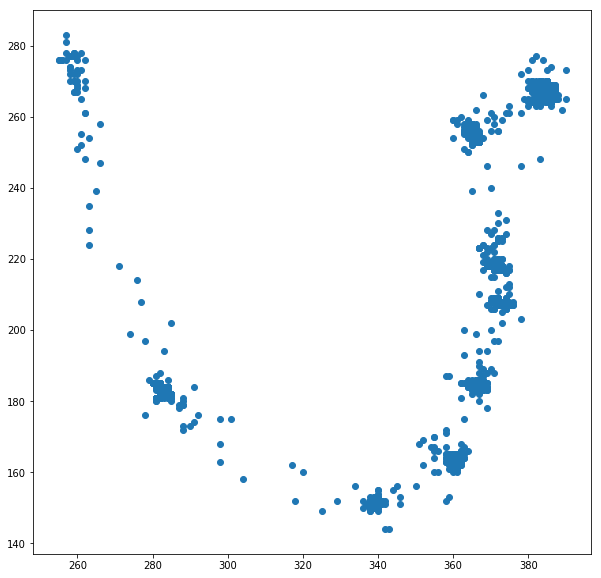

In [10]:
plt.figure(figsize = (10, 10))
plt.scatter(x_coor, y_coor)

output = [x_coor, y_coor]
fields = ["x","y"]

with open(location + filename[:-4] + "coordinates.csv", "w") as csv_file:
    csvwriter = csv.writer(csv_file)
    csvwriter.writerow(fields)
    for i in range(len(output[0])):
        csvwriter.writerow([output[0][i], output[1][i]])

In [13]:
dist = []
vel = []

for i in range(len(x_coor) - 1):
    distance = ((x_coor[i + 1] - x_coor[i])**2 + (y_coor[i + 1] - y_coor[i])**2)**0.5
    if distance <= 0:
        dist.append(0)
    else:
        dist.append(distance)
    #if i != 0:
        #dist[-1] += dist[-2]

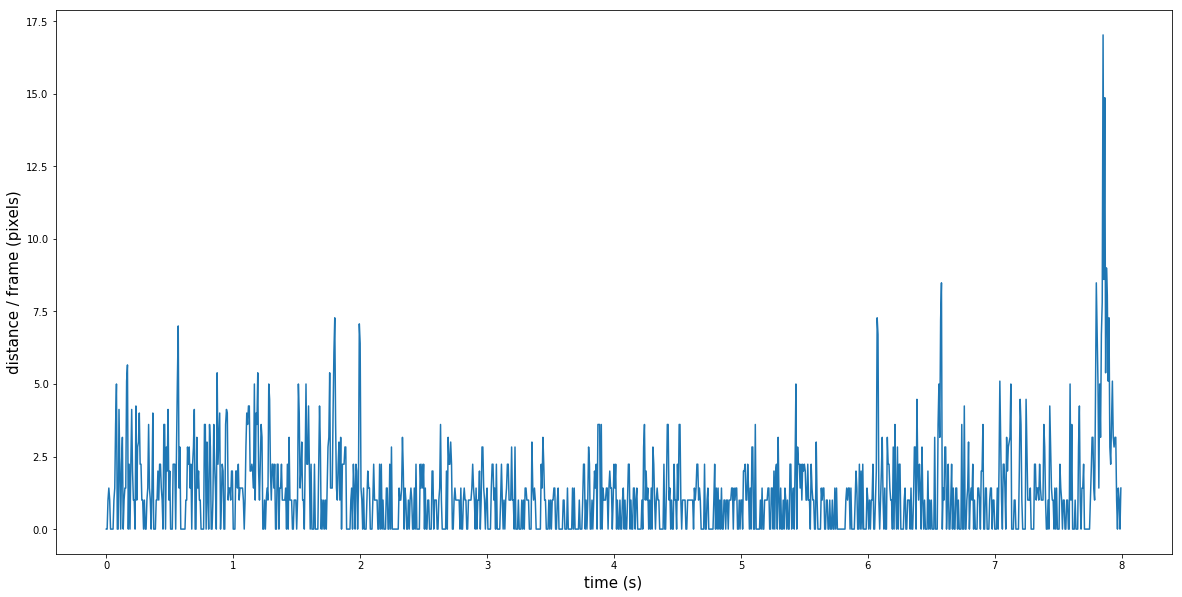

In [14]:
dist[0] = 0
plt.figure(figsize = (20, 10))
plt.plot(np.arange(0, 8, 0.0066667), dist[:1200])
plt.xlabel("time (s)", fontsize = 15)
plt.ylabel("distance / frame (pixels)", fontsize = 15)
plt.savefig("./dist_time_plot.png")

In [ ]:
# x_coor = []
# y_coor = []
# cap = cv2.VideoCapture(location + filename)
# while True:
#     ret, frame = cap.read()
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     frame = cv2.convertScaleAbs(frame * 1.75)
#     corners = cv2.goodFeaturesToTrack(frame, 2, 0.5, 5)
#     x_avg = 0
#     y_avg = 0
#     for i in corners:
#         x, y = i.ravel()
#         x_avg += x
#         y_avg += y
#         #cv2.circle(frame, (x, y), 1, 255, -1)
#         #cv2.imshow("corners", frame)
#     cv2.circle(frame, (int(x_avg/2), int(y_avg/2)), 1, 255, -1)
#     cv2.imshow("fish", frame)
#     x_coor.append(int(x_avg/2))
#     y_coor.append(int(y_avg/2))
        
#     if cv2.waitKey(1) & 0xff == ord("q"):
#             break
# cap.release()
# cv2.destroyAllWindows()

In [ ]:
# cv2.imshow("frame", cv2.convertScaleAbs((copy - bg) * 0.5))
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [7]:
(1, 2) == 1

False